In [1]:
import torch

import triton
import triton.language as tl

# Introduction to Triton

Models developed with frameworks like PyTorch often rely on generic and un-optimized operator implementations. Accordingly, you can dramatically decrease a model's latency perfomance by introducing optimized operators or kernels. Unfortunately, this has been remarkably difficult to do, thanks to the complexity of developing efficient CUDA programs. 

OpenAI's Triton library changed all of this. Triton is an intermediate-level language and compiler that makes it much, much easier for deep learning developers to write optimized GPU kernels. Instead of implementing kernels in CUDA, Triton allows you to decorate python functions with a JIT-compiler that pretty much magics away your latency. 

However, while it *is* much easier to develop optimized kernels with Triton, the learning curve is still quite steep, especially if you're not familiar with CUDA. That, combined with the relatively limited Triton documentation makes it difficult for the uninitiated to get started. 



These materials are designed to provide a well-documented tour through CUDA, GPUs, Triton, and 





 Tillet, Kung, and Cox (2019) introduced Triton and Tillet continued developing it at OpenAI. Then, in 2021, Triton 1.0 was open sourced. Triton's core innovation is to provide a framework for expressing tensor programs (i.e. neural networks) with parametric tile variables. 

**References**

CUDA & GPUs

Wikipedia contributors. 2023. “CUDA.” Wikipedia, The Free Encyclopedia. February 15, 2023. https://en.wikipedia.org/w/index.php?title=CUDA&oldid=1139470962.

https://nichijou.co/cuda1/

http://thebeardsage.com/cuda-streaming-multiprocessors/

https://www.microway.com/hpc-tech-tips/cuda-parallel-thread-management/

https://pgroup.com/blogs/posts/cuda-threading-model.htm

http://courses.cms.caltech.edu/cs179/Old/2015_lectures/cs179_2015_lec05.pdf

https://www.tutorialspoint.com/cuda/cuda_caches.htm

## Triton

Tillet, Philippe, H. T. Kung, and David Cox. 2019. “Triton: An Intermediate Language and Compiler for Tiled Neural Network Computations.” In Proceedings of the 3rd ACM SIGPLAN International Workshop on Machine Learning and Programming Languages, 10–19. MAPL 2019. New York, NY, USA: Association for Computing Machinery. https://dl.acm.org/doi/abs/10.1145/3315508.3329973



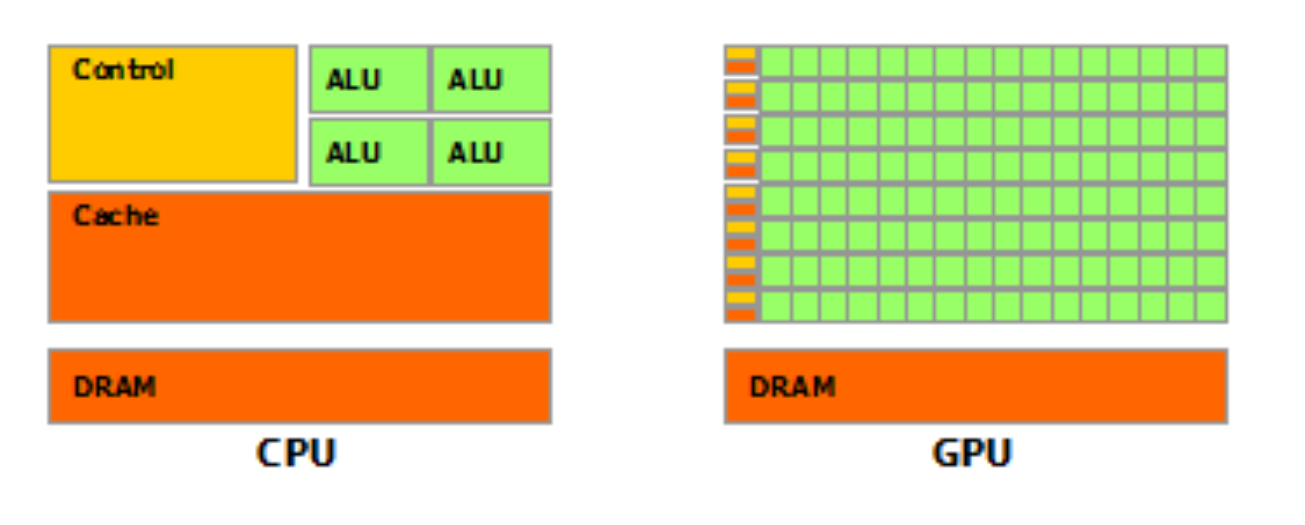


### The CUDA Programming Model

**Terminology**

* **Block.** Block IDs can be 1D or 2D. 
* **Grid.** 
* **Streaming Multiprocessors.** 
* **Thread.** Thread IDs can be 1D, 2D, or 3D
* **Warp.** A set of 32 threads within a thread block that


*Notes*

CUDA programmers must declare the size of a block (i.e. its number of concurrent threads), the block's dimensions (1D, 2D, or 3D), and the block dimensions in threads. All threads within a block are able to share data and synchronize. 

# Introduction to CUDA

## The CUDA Programming Model

CUDA (Compute Unified Device Architecture) is a platform and API that allows software to execute computations on GPUs. It provides direct access to the GPU and supports the execution of compute kernels (Wikipedia, 2023). Compute kernels are routines that have been compiled for execution on accelerators such as GPUs. 

To describe how kernel execution is orchestrated, we first need to define a set of core concepts: 

* **Thread.** An abstract entity that represents the smallest execution unit in a CUDA program. Every thread is associatd with a unique index. 

* **Block.** An abstract entity that represents a group of threads. The number of threads assigned to a block is program-dependent; however, the maximum is currently 1024. Thread blocks can be organized and indexed as either 1D, 2D, or 3D arrays of threads. The maximum x,y, and z dimensions of a block are `1024`, `1024`, and `64` and `x * y * z <= 1024`, as `1024` is the maximum number of threads per block.

* **Grid.** An abstract entity that represents a group of blocks. Like blocks, grids can be specified as 1D, 2D, or 3D arrays of 2^31-1, 65,535, and 65,535 blocks in the x, y, and z dimensions, respectively. Grids are also sometimes referred to as *kernel grids*. 

* **Streaming Multiprocessors.** Every GPU consists of multiple Streaming Multiprocessors (SMs). SMs are general purpose processors that are able to execute a several thread blocks in parallel. In other words, SMs are the part of a GPU that execute thread blocks. 

* **Warp.** From the hardware perspective, a thread block is composed of *warps*. A warp is a set of 32 threads within a thread block that all simultaneously execute the same instruction. Warps are units of thread scheduling.

Now we can describe the steps involved in kernel execution: 

1. *The host CPU invokes a kernel grid via a CUDA program*. Among other things, this step defines the dimensionality of the grid and blocks. 

2. *Blocks are enumerated and scheduled to SMs with available capacity*.

3. *The threads in scheduled blocks are executed by scheduling warp execution*. 

4. *As blocks terminate, new blocks are scheduled according to SM capacity*.


CUDA code achieves parallelism via the *single instruction, multiple data* (SIMD) paradigm. At any point in time, a single instruction can be fetched and executed for all threads in a warp, such that each thread in the warp will apply the same instruction to different portions of an input. "




## Memory Management for Cuda Programs

Like CPUs, SMs are general-purpose processors. However, they're designed to support very different workloads. In contrast to CPUs, GPUs target lower clock rates and they have less cache. However, a GPU's relatively low clock rate is compensated by its ability to execute operations in parallel.

GPU memory consists of the following components:

* **Global memory.** Primary GPU memory. Global memory is characterized by a global scope and it persists through the lifetime of the allocating program or until it is cleared. In terms of hardware, global memory is separate from the GPU core, which contains components like SMs and caches. Global memory IO is the slowest GPU IO. Accordingly, we want to minimize global memory access when designing CUDA programs. 

* **Constant memory.** Used to store constants that cannot be compiled. Part of global memory, but very fast. All threads have access to the same constant memory, but it is read-only.

* **Shared memory.** Fast memory located in SMs. Shared memory is scoped at the block level. It can be declared at compile time (statically) or runtime (dynamically). It is used to facilitate fast communication between threads in a block.

* **Registers.** The fastest memory available in a GPU. Registers are scoped to the thread level. Register storage is not permanent–persistance ends with with  thread execution. 

* **Local memory.** Slow memory that is scoped at the thread level and resides off chip. It is actually an abstraction of global memory. Local memory is used by threads when registers are full or cannot be used. 

* **L1 cache.** Depending on the GPU model, caches either local and global memory or just local memory. Currently designed with SRAM. 

* **L2 cache.** A cache that caches all global and local memory accesses and is shared by all threads across all SMs. Currently designed with DRAM. 
 
* **Texture memory.**

* **Read-only cache.**

* **DRAM.** Dynamic RAM. The most common but also slowest RAM in GPUs today. To persist data, it requires refreshing multiple times a second. Accoridingly, it's relatively power hungry. 

* **SRAM.** Substantially faster than DRAM, but also more expensive. Does not require refreshing to persist data. 



# Triton

## What is Triton?

Triton is an intermediate-level language and compiler that makes it easier for deep learning developers to write GPU kernels. Tillet, Kung, and Cox (2019) introduced Triton and Tillet continued developing it at OpenAI. Then, in 2021, Triton 1.0 was open sourced. Triton's core innovation is to provide a framework for expressing tensor programs (i.e. neural networks) with parametric tile variables. 

Tile, a "statically shaped multi-dimensional sub-array."

[INCLUDE Figure 2. from Triton picture here] 


Tillet, Philippe, H. T. Kung, and David Cox. 2019. “Triton: An Intermediate Language and Compiler for Tiled Neural Network Computations.” In Proceedings of the 3rd ACM SIGPLAN International Workshop on Machine Learning and Programming Languages, 10–19. MAPL 2019. New York, NY, USA: Association for Computing Machinery. https://dl.acm.org/doi/abs/10.1145/3315508.3329973


### @triton.jit decorator

The `@triton.jit` decorator triggers [JIT](https://en.wikipedia.org/wiki/Just-in-time_compilation)-compilation of the decorated function. Triton jit'd functions are compiled and run on a GPU.  As written in the help doc, when "a jit'd function is called, `torch.tensor` arguments are implicitly converted to pointers using the `.data_ptr()` method." Further, they only have access to:

   * python primitives,
   * builtins within the triton package,
   * arguments to this function,
   * other jit'd functions
   
According to [this blog post](https://analyticssteps.com/blogs/openai-triton-programming-language-neural-networks), Triton kernels are single threaded, such that they process one command at a time. 

### Vector addition kernel

Below, we'll implement a vector addition kernel and decorate it with `@triton.jit`. 



The Triton class `constexpr` is used to store a value that is known at compile-time.

The Triton function `program_id` returns the id of the current program instance along the given `axis`. The axis referes to the axis of the 3D launch grid and it must be either 0, 1, or 2. For example, if your program uses a 1D launch grid, the axis should be 0. 




In [13]:
help(tl.program_id)

Help on function program_id in module triton.language.core:

program_id(axis, _builder=None)
    Returns the id of the current program instance along the given :code:`axis`.
    
    :param axis: The axis of the 3D launch grid. Has to be either 0, 1 or 2.
    :type axis: int



In [2]:
@triton.jit
def add_kernel(
    x_ptr,  # *Pointer* to first input vector
    y_ptr,  # *Pointer* to second input vector
    output_ptr,  # *Pointer* to output vector
    n_elements,  # Size of the vector
    BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process
                 # NOTE: `constexpr` so it can be used as a shape value
):
    # There are multiple 'program's processing different data. We identify which program
    # we are here
    pid = tl.program_id(axis=0)  # We use a 1D launch grid so axis is 0
    # This program will process inputs that are offset from the initial data.
    # for instance, if you had a vector of length 256 and block_size of 64, the programs
    # would each access the elements [0:64, 64:128, 128:192, 192:256].
    # Note that offsets is a list of pointers
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    # Create a mask to guard memory operations against out-of-bounds accesses
    mask = offsets < n_elements
    # Load x and y from DRAM, masking out any extra elements in case the input is not a
    # multiple of the block size
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    # Write x + y back to DRAM
    tl.store(output_ptr + offsets, output, mask=mask)

In [3]:
def add(x: torch.Tensor, y: torch.Tensor):
    # We need to preallocate the output
    output = torch.empty_like(x)
    assert x.is_cuda and y.is_cuda and output.is_cuda
    n_elements = output.numel()
    # The SPMD launch grid denotes the number of kernel instances that run in parallel.
    # It is analogous to CUDA launch grids. It can be either Tuple[int], or Callable(metaparameters) -> Tuple[int]
    # In this case, we use a 1D grid where the size is the number of blocks
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)
    # NOTE:
    #  - each torch.tensor object is implicitly converted into a pointer to its first element.
    #  - `triton.jit`'ed functions can be index with a launch grid to obtain a callable GPU kernel
    #  - don't forget to pass meta-parameters as keywords arguments
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    # We return a handle to z but, since `torch.cuda.synchronize()` hasn't been called, the kernel is still
    # running asynchronously at this point.
    return output

In [4]:
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device='cuda')
y = torch.rand(size, device='cuda')
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(
    f'The maximum difference between torch and triton is '
    f'{torch.max(torch.abs(output_torch - output_triton))}'
)

tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
The maximum difference between torch and triton is 0.0


In [5]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # argument names to use as an x-axis for the plot
        x_vals=[
            2 ** i for i in range(12, 28, 1)
        ],  # different possible values for `x_name`
        x_log=True,  # x axis is logarithmic
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg`
        line_names=['Triton', 'Torch'],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel='GB/s',  # label name for the y-axis
        plot_name='vector-add-performance',  # name for the plot. Used also as a file name for saving the plot.
        args={},  # values for function arguments not in `x_names` and `y_name`
    )
)
def benchmark(size, provider):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    y = torch.rand(size, device='cuda', dtype=torch.float32)
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y))
    gbps = lambda ms: 12 * size / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


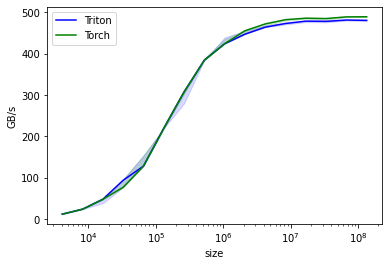

vector-add-performance:
           size      Triton       Torch
0        4096.0   12.000000   12.000000
1        8192.0   24.000000   24.000000
2       16384.0   48.000000   48.000000
3       32768.0   93.801531   76.800002
4       65536.0  127.999995  127.999995
5      131072.0  219.428568  219.428568
6      262144.0  307.200008  307.200008
7      524288.0  384.000001  384.000001
8     1048576.0  423.724127  423.724127
9     2097152.0  446.836360  455.111110
10    4194304.0  463.698115  471.623386
11    8388608.0  472.615390  481.882362
12   16777216.0  478.364979  485.451853
13   33554432.0  477.783730  484.554523
14   67108864.0  480.998167  488.599838
15  134217728.0  480.117211  488.922591


In [6]:
benchmark.run(print_data=True, show_plots=True)